## Setting up SocialPain & Mentalizing Network Regions and extracting timeseries

In [1]:
#importing libraries
%matplotlib inline
from __future__ import print_function, division
from scipy.io import matlab
from scipy import stats
from IPython.display import Image, HTML

import os, re, nilearn, nibabel
import numpy as np
import sys
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
from nilearn import image, plotting, input_data
from nilearn.connectome import ConnectivityMeasure
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
import sklearn

print('Version Numpy: %s '  %(np.__version__))
print('Version Scipy: %s '  %(scipy.__version__))
print('Version Nilearn: %s '  %(nilearn.__version__))
print('Version Sklearn: %s '  %(sklearn.__version__))

os.environ['LD_PRELOAD']='/data00/tools/Canopy_64bit/User/lib/libmkl_core.so:/data00/tools/Canopy_64bit/User/lib/libmkl_rt.so'

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide(); } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
The raw code for this IPython notebook is by default hidden for easier reading.
To toggle on/off the raw code, click <a href="javascript:code_toggle()">here</a>.''')


Version Numpy: 1.11.0 
Version Scipy: 0.16.1 
Version Nilearn: 0.2.1 
Version Sklearn: 0.17.1 


In [2]:
#### Define methods to extract data
# extract_confounds - get means from anatomy segmented masks
# clean_time_series - use confounds to clean time series
# get_TR_ranges - get TR ranges for trials in the functional task
#### function to extract confounds from time series for a subject

def extract_confounds(path, nifti_file, plot=False):
    '''
        take a NIFTI file from a run and
        return the confounds from movement parameters
        and anatomical segmentation
        
        params:
           * path - path to directory containing nifti file  
           * nifti_file - usually the final stage of preprocessing, e.g. ad_ ... .nii
                          function assumes same folder has the realignment parameters, e.g.
                          rp_ad_.txt
           * plot (optional) - if True then plot slices of the anatomical masks
           
        returns:
            * hv_confounds - high variance confounds
            * matter_confounds - white, gray matter and csf means removed
    '''

    # get the subj id from the path
    subj_id = re.findall('/([^/]+)/BOLD',path)[0]
    
    func_filename = os.path.join(path, nifti_file)  #preprocessed data
                                         
    hv_confounds = nilearn.image.high_variance_confounds(func_filename) #high variance confounds
        
    cut_coords = (0, 0, 0)

    anatomy_dir = re.sub('BOLD/.*','anatomy', path)
    
    t1img = nibabel.load(os.path.join(anatomy_dir, 'regt1spgr.nii'))
    
    # Get Confounds: White Matter + CSF/Ventricles 
    
    matter_confounds = None   

    for c in range(2,4):  #I changed this to 2:4 to get only white matter and CSF - no gray matter...
        m_filename = 'wc'+ str(c) + 'regt1spgr.nii'
        m_filepath = os.path.join(anatomy_dir, m_filename)

        anat_img = nibabel.load(m_filepath);
        m_hand_mask = anat_img.get_data();
        
        m_hand_mask = np.where(m_hand_mask > 0.7, 1, 0)

        m_anat_img = nibabel.Nifti1Image(m_hand_mask, anat_img.affine) 
        
        if plot:
            plotting.plot_anat(m_anat_img, cut_coords=cut_coords,title=('{} {}'.format(subj_id, m_filename)));
        
    
        m_masker = input_data.NiftiLabelsMasker(labels_img = m_anat_img, 
                                                standardize=True, 
                                                memory='nilearn_cache', verbose=0)
        
        ts = m_masker.fit_transform(func_filename)
        
        if matter_confounds is None:
                        matter_confounds = ts

        else:
                matter_confounds = np.append(matter_confounds, ts, axis=1)

    
    return hv_confounds, matter_confounds

In [3]:
def clean_time_series(path, nifti_file, networks_coords, hv_confounds=None, matter_confounds=None, fd_thresh = None, plot=None):  
    
    # get the subj id from the path
    subj_id = re.findall('/([^/]+)/BOLD',path)[0]
    
    func_filename = os.path.join(path, nifti_file)  #preprocessed data

    conf_filename = os.path.join(path, 'rp_adrun_04.txt')  #motion confounds
        
    if matter_confounds is None or hv_confounds is None:
        hv_confounds, matter_confounds = extract_confounds(path, nifti_file)
    
    masker = input_data.NiftiSpheresMasker(networks_coords, 
                                           radius=8, 
                                           allow_overlap=True, 
                                           detrend=True, 
                                           standardize=True, 
                                           low_pass=0.12, high_pass=0.06, 
                                           t_r=2,  
                                           memory='nilearn_cache', memory_level=1); #verbose=2 by default nothing should be printed
        
    cleaned_time_series = masker.fit_transform(func_filename,confounds=[conf_filename, matter_confounds, hv_confounds])  

    if fd_thresh>0:     
        FD = compute_fd(conf_filename)
        bad_fd_vols  = np.where(FD > fd_thresh, 1,0)
    else:
        bad_fd_vols = []
   # if plot:
   #     cm = np.corrcoef(clean_time_series.T)
   #     f, ((ax1, ax2)) = plt.subplots(1, 2, sharex='col', sharey='row', figsize=(10,5))
   #     ax1.plot(cleaned_time_series.T);
   #     ax1.set_title('Subj: {} Clean time series'.format(subj_id)) 
        
    return cleaned_time_series,  FD, bad_fd_vols

In [4]:
def get_TR_ranges(path, subject):
   # Get the Onsets for Fair and Unfair Runs
    behav = matlab.loadmat(os.path.join(path ,subjs[n],'behav','{}.mat'.format(subjs[n])))  
    conds = behav['trials'][0]
  
    #print(subjs[n])
    if len(conds) > 5:     
        fair_trials = conds[4][0];           fair_onset = fair_trials[0]['onset']
        unfair_trials = conds[5][0];         unfair_onset = unfair_trials[0]['onset']
              
        fair_extent = (fair_trials[0]['onset'], fair_trials[-1]['onset'] + fair_trials[-1]['rt'])
        unfair_extent = (unfair_trials[0]['onset'], unfair_trials[7]['onset']+unfair_trials[7]['rt'], unfair_trials[8]['onset'], unfair_trials[-1]['onset'] + unfair_trials[-1]['rt'])
        
        fair_extent_TR = int(fair_extent[0]/2), int(fair_extent[-1]/2)
        unfair_extent_TR = int(unfair_extent[0]/2), int(unfair_extent[-1]/2)      
    else:
        print('Error - subject' + subject)
    return fair_extent_TR, unfair_extent_TR

In [5]:
def compute_fd(conf_filename):
    # This function is based on Powers 2012 as well as Bramila tools and 
    # Poldracks fMRI QA script. Important note: It assumes the input is a 
    # SPM-realignment parameter file. FSL uses a different ordering and 
    # thus cannot be used blindly... Beware!

    motpars = pd.read_csv(conf_filename, header=None, delimiter=r"\s+")
    motpars = motpars.as_matrix()

    # compute absolute displacement
    dmotpars=np.zeros(motpars.shape)
    
    dmotpars[1:,:]=np.abs(motpars[1:,:] - motpars[:-1,:])
    
    # convert rotation to displacement on a 50 mm sphere
    # mcflirt returns rotation in radians
    # from Jonathan Power:
    # The conversion is simple - you just want the length of an arc that a rotational
    # displacement causes at some radius. Circumference is pi*diameter, and we used a 5
    # 0 mm radius. Multiply that circumference by (degrees/360) or (radians/2*pi) to get the 
    # length of the arc produced by a rotation.  
    headradius=50
    disp=dmotpars.copy()
    disp[:,3:6]=np.pi*headradius*2*(disp[:,3:6]/(2*np.pi))
    
    FD=np.sum(disp,1)
      
    return FD

In [6]:
def plot_data_fd(timeseries, FD, FD_thresh, subj):
    # takes input timeseries [nsamples, nnodes] and FD parameters as input
    # have to be same length!
    
    fig = plt.figure()
    fig.suptitle(subj, fontsize=12)

    ax1 = plt.subplot(2, 1, 1)
    ax1.plot(FD)
    ax1.axhline(y=FD_thresh, color = 'red')           
    ax1.set_title('Framewise Displacement')
    ax1.set_ylabel('FD')
    ax1.set_ylim(0,2)
    ax1.set_xticklabels([])

    ax2 = plt.subplot(2, 1, 2, sharex = ax1)
    cmap = plt.cm.jet
    ax2.imshow(timeseries.T, interpolation="none", cmap = 'jet', aspect='auto', clim=(-3, 3))
    
    #plt.colorbar()
    
    ax2.grid(b=False) 
    ax2.set_ylim(0,len(timeseries.T))
    ax2.set_title('BOLD Values')
    ax2.set_ylabel('Node #')
    ax2.set_xlabel('Time [TR]')
    plt.show()

### 1. Set up networks and variables

* Ran an automated Neurosynth Meta-Analysis 
* Reconciled with Curated Meta-Analyses (Schurz et al.) for Mentalizing and Social Pain/Cyberball (Rotge et al.)
* Symmetrized Nodes

/data00/tools/Canopy_64bit/User/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


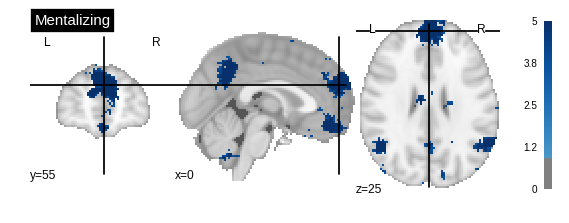

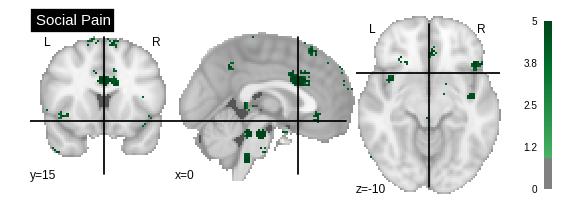

In [11]:
from nilearn import plotting
os.chdir('/data00/projects/can_cta/scripts/ipython/Neurosynth_Node')
plotting.plot_stat_map('pFgA_mentali_z_FDR_0.01.nii.gz',         threshold=1, title="Mentalizing", vmax =5, cmap = 'Blues');
plotting.plot_stat_map('pFgA_social_And_pain_z_FDR_0.01.nii.gz', threshold=1, title="Social Pain", vmax =5, cmap = 'Greens', cut_coords = [0, 15,-10]);

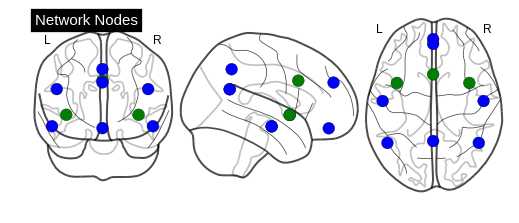

In [12]:
networks_coords = [ (0,16,32),    #SAL/SocialPain - dACC
                    (38,7,-4),    #SAL/SocialPain - raINS
                    (-38,7,-4),   #SAL/SocialPain - laINS
                    (0,53,30),    #MENT/DMN - DMPFC
                    (0,48,-18),    #MENT/DMN - VMPFC
                    (0,-54,44),   #MENT/DMN - Precun
                    (48,-56,23),   #MENT/DMN - rTPJ
                    (-48,-56,23), #MENT/DMN - lTPJ                   
                    (53,-12,-16), #MENT/DMN - rMTG
                    (-53,-12,-16)]#MENT/DMN - lMTG

n_nodes = len(networks_coords)

networks_cols = ['green',
                 'green',
                 'green',
                 'blue',
                 'blue',
                 'blue',
                 'blue',
                 'blue',
                 'blue',
                 'blue']
node_sizes =  np.array([7,7,7,7,7,7,7,7,7,7])                

networks_labels = ['dACC_SP', 'raINS_SP', 'laINS_SP', 'DMPFC_Men', 'VMPFC_Men', 'Precun_Men', 'rTPJ_Men', 'lTPJ_Men', 'rMTG_Men', 'lMTG_Men']
                  
plotting.plot_connectome(np.zeros((n_nodes,n_nodes)), networks_coords, node_size = node_sizes*20, node_color= networks_cols, title="Network Nodes");

### 2. Import and set up subjects
We start by importing libraries and defining the subjects

In [13]:
data_dir = '/data00/projects/can_cta/data'
bad_subjs = ('TPS1F0018', 'TPS1F0036')
subjs = [s for s in os.listdir(os.path.join(data_dir,'subjs')) if re.match('TPS1',s) and s not in bad_subjs]
n_subjs = len(subjs)
print('We have %d subjects' % (n_subjs) )

We have 39 subjects


### 3. Extract clean data from individual subjects, compute connectivity matrix, save time_series and matrices
Here we extract the data from individual subjects during i) social inclusion - aka fair and ii) social exclusion - aka unfair trials. Cleaning the data is accomplished by regressing out motion confounds, gray- and white matter as well as CSF, and finally the high-variance-confound methods (similar to compcorr).


/data00/tools/Canopy_64bit/User/lib/python2.7/site-packages/sklearn/externals/joblib/hashing.py:197: DeprecationWarning: Changing the shape of non-C contiguous array by
descriptor assignment is deprecated. To maintain
the Fortran contiguity of a multidimensional Fortran
array, use 'a.T.view(...).T' instead
  obj_bytes_view = obj.view(self.np.uint8)
/data00/tools/Canopy_64bit/User/lib/python2.7/site-packages/sklearn/externals/joblib/hashing.py:197: DeprecationWarning: Changing the shape of non-C contiguous array by
descriptor assignment is deprecated. To maintain
the Fortran contiguity of a multidimensional Fortran
array, use 'a.T.view(...).T' instead
  obj_bytes_view = obj.view(self.np.uint8)
/data00/tools/Canopy_64bit/User/lib/python2.7/site-packages/sklearn/externals/joblib/hashing.py:197: DeprecationWarning: Changing the shape of non-C contiguous array by
descriptor assignment is deprecated. To maintain
the Fortran contiguity of a multidimensional Fortran
array, use 'a.T.view(...).T

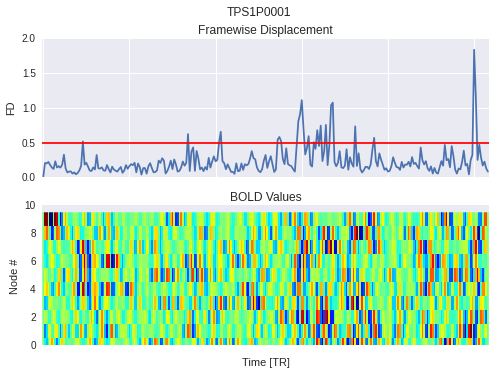

/data00/tools/Canopy_64bit/User/lib/python2.7/site-packages/sklearn/externals/joblib/hashing.py:197: DeprecationWarning: Changing the shape of non-C contiguous array by
descriptor assignment is deprecated. To maintain
the Fortran contiguity of a multidimensional Fortran
array, use 'a.T.view(...).T' instead
  obj_bytes_view = obj.view(self.np.uint8)
/data00/tools/Canopy_64bit/User/lib/python2.7/site-packages/sklearn/externals/joblib/hashing.py:197: DeprecationWarning: Changing the shape of non-C contiguous array by
descriptor assignment is deprecated. To maintain
the Fortran contiguity of a multidimensional Fortran
array, use 'a.T.view(...).T' instead
  obj_bytes_view = obj.view(self.np.uint8)
/data00/tools/Canopy_64bit/User/lib/python2.7/site-packages/sklearn/externals/joblib/hashing.py:197: DeprecationWarning: Changing the shape of non-C contiguous array by
descriptor assignment is deprecated. To maintain
the Fortran contiguity of a multidimensional Fortran
array, use 'a.T.view(...).T

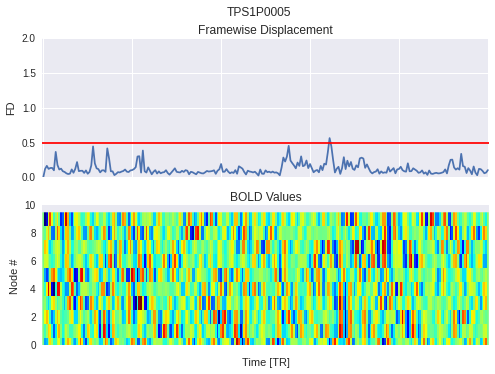

/data00/tools/Canopy_64bit/User/lib/python2.7/site-packages/sklearn/externals/joblib/hashing.py:197: DeprecationWarning: Changing the shape of non-C contiguous array by
descriptor assignment is deprecated. To maintain
the Fortran contiguity of a multidimensional Fortran
array, use 'a.T.view(...).T' instead
  obj_bytes_view = obj.view(self.np.uint8)
/data00/tools/Canopy_64bit/User/lib/python2.7/site-packages/sklearn/externals/joblib/hashing.py:197: DeprecationWarning: Changing the shape of non-C contiguous array by
descriptor assignment is deprecated. To maintain
the Fortran contiguity of a multidimensional Fortran
array, use 'a.T.view(...).T' instead
  obj_bytes_view = obj.view(self.np.uint8)
/data00/tools/Canopy_64bit/User/lib/python2.7/site-packages/sklearn/externals/joblib/hashing.py:197: DeprecationWarning: Changing the shape of non-C contiguous array by
descriptor assignment is deprecated. To maintain
the Fortran contiguity of a multidimensional Fortran
array, use 'a.T.view(...).T

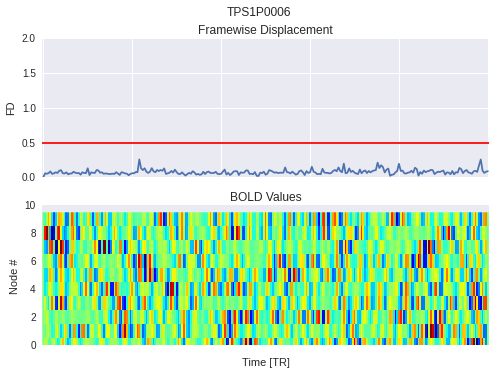

/data00/tools/Canopy_64bit/User/lib/python2.7/site-packages/sklearn/externals/joblib/hashing.py:197: DeprecationWarning: Changing the shape of non-C contiguous array by
descriptor assignment is deprecated. To maintain
the Fortran contiguity of a multidimensional Fortran
array, use 'a.T.view(...).T' instead
  obj_bytes_view = obj.view(self.np.uint8)
/data00/tools/Canopy_64bit/User/lib/python2.7/site-packages/sklearn/externals/joblib/hashing.py:197: DeprecationWarning: Changing the shape of non-C contiguous array by
descriptor assignment is deprecated. To maintain
the Fortran contiguity of a multidimensional Fortran
array, use 'a.T.view(...).T' instead
  obj_bytes_view = obj.view(self.np.uint8)
/data00/tools/Canopy_64bit/User/lib/python2.7/site-packages/sklearn/externals/joblib/hashing.py:197: DeprecationWarning: Changing the shape of non-C contiguous array by
descriptor assignment is deprecated. To maintain
the Fortran contiguity of a multidimensional Fortran
array, use 'a.T.view(...).T

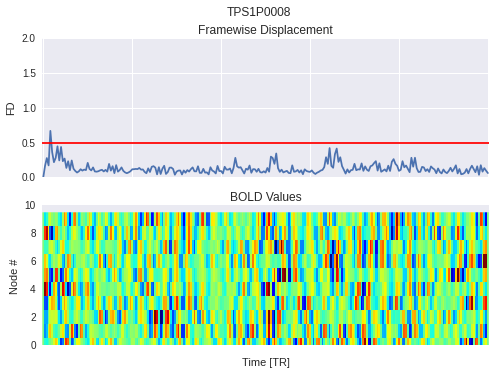

/data00/tools/Canopy_64bit/User/lib/python2.7/site-packages/sklearn/externals/joblib/hashing.py:197: DeprecationWarning: Changing the shape of non-C contiguous array by
descriptor assignment is deprecated. To maintain
the Fortran contiguity of a multidimensional Fortran
array, use 'a.T.view(...).T' instead
  obj_bytes_view = obj.view(self.np.uint8)
/data00/tools/Canopy_64bit/User/lib/python2.7/site-packages/sklearn/externals/joblib/hashing.py:197: DeprecationWarning: Changing the shape of non-C contiguous array by
descriptor assignment is deprecated. To maintain
the Fortran contiguity of a multidimensional Fortran
array, use 'a.T.view(...).T' instead
  obj_bytes_view = obj.view(self.np.uint8)
/data00/tools/Canopy_64bit/User/lib/python2.7/site-packages/sklearn/externals/joblib/hashing.py:197: DeprecationWarning: Changing the shape of non-C contiguous array by
descriptor assignment is deprecated. To maintain
the Fortran contiguity of a multidimensional Fortran
array, use 'a.T.view(...).T

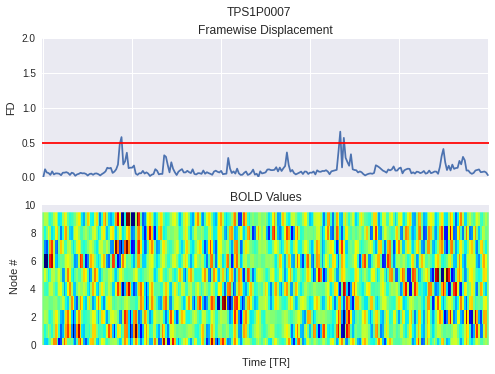

/data00/tools/Canopy_64bit/User/lib/python2.7/site-packages/sklearn/externals/joblib/hashing.py:197: DeprecationWarning: Changing the shape of non-C contiguous array by
descriptor assignment is deprecated. To maintain
the Fortran contiguity of a multidimensional Fortran
array, use 'a.T.view(...).T' instead
  obj_bytes_view = obj.view(self.np.uint8)
/data00/tools/Canopy_64bit/User/lib/python2.7/site-packages/sklearn/externals/joblib/hashing.py:197: DeprecationWarning: Changing the shape of non-C contiguous array by
descriptor assignment is deprecated. To maintain
the Fortran contiguity of a multidimensional Fortran
array, use 'a.T.view(...).T' instead
  obj_bytes_view = obj.view(self.np.uint8)
/data00/tools/Canopy_64bit/User/lib/python2.7/site-packages/sklearn/externals/joblib/hashing.py:197: DeprecationWarning: Changing the shape of non-C contiguous array by
descriptor assignment is deprecated. To maintain
the Fortran contiguity of a multidimensional Fortran
array, use 'a.T.view(...).T

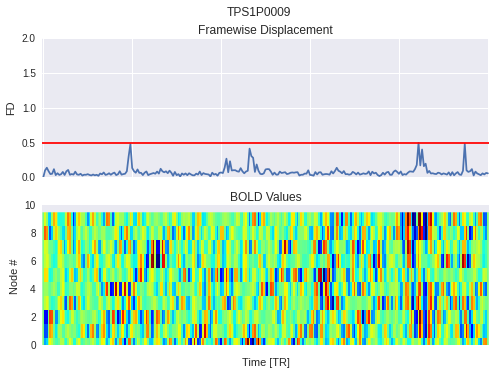

/data00/tools/Canopy_64bit/User/lib/python2.7/site-packages/sklearn/externals/joblib/hashing.py:197: DeprecationWarning: Changing the shape of non-C contiguous array by
descriptor assignment is deprecated. To maintain
the Fortran contiguity of a multidimensional Fortran
array, use 'a.T.view(...).T' instead
  obj_bytes_view = obj.view(self.np.uint8)
/data00/tools/Canopy_64bit/User/lib/python2.7/site-packages/sklearn/externals/joblib/hashing.py:197: DeprecationWarning: Changing the shape of non-C contiguous array by
descriptor assignment is deprecated. To maintain
the Fortran contiguity of a multidimensional Fortran
array, use 'a.T.view(...).T' instead
  obj_bytes_view = obj.view(self.np.uint8)
/data00/tools/Canopy_64bit/User/lib/python2.7/site-packages/sklearn/externals/joblib/hashing.py:197: DeprecationWarning: Changing the shape of non-C contiguous array by
descriptor assignment is deprecated. To maintain
the Fortran contiguity of a multidimensional Fortran
array, use 'a.T.view(...).T

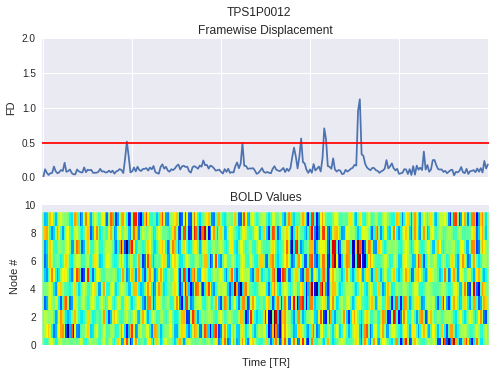

/data00/tools/Canopy_64bit/User/lib/python2.7/site-packages/sklearn/externals/joblib/hashing.py:197: DeprecationWarning: Changing the shape of non-C contiguous array by
descriptor assignment is deprecated. To maintain
the Fortran contiguity of a multidimensional Fortran
array, use 'a.T.view(...).T' instead
  obj_bytes_view = obj.view(self.np.uint8)
/data00/tools/Canopy_64bit/User/lib/python2.7/site-packages/sklearn/externals/joblib/hashing.py:197: DeprecationWarning: Changing the shape of non-C contiguous array by
descriptor assignment is deprecated. To maintain
the Fortran contiguity of a multidimensional Fortran
array, use 'a.T.view(...).T' instead
  obj_bytes_view = obj.view(self.np.uint8)
/data00/tools/Canopy_64bit/User/lib/python2.7/site-packages/sklearn/externals/joblib/hashing.py:197: DeprecationWarning: Changing the shape of non-C contiguous array by
descriptor assignment is deprecated. To maintain
the Fortran contiguity of a multidimensional Fortran
array, use 'a.T.view(...).T

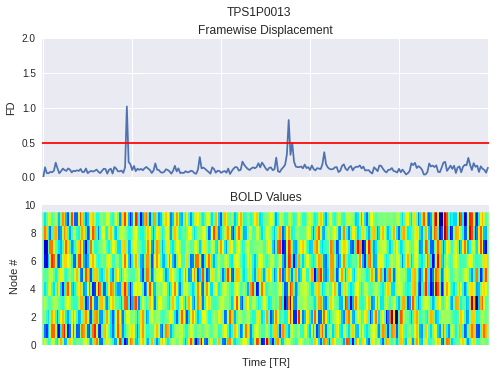

/data00/tools/Canopy_64bit/User/lib/python2.7/site-packages/sklearn/externals/joblib/hashing.py:197: DeprecationWarning: Changing the shape of non-C contiguous array by
descriptor assignment is deprecated. To maintain
the Fortran contiguity of a multidimensional Fortran
array, use 'a.T.view(...).T' instead
  obj_bytes_view = obj.view(self.np.uint8)
/data00/tools/Canopy_64bit/User/lib/python2.7/site-packages/sklearn/externals/joblib/hashing.py:197: DeprecationWarning: Changing the shape of non-C contiguous array by
descriptor assignment is deprecated. To maintain
the Fortran contiguity of a multidimensional Fortran
array, use 'a.T.view(...).T' instead
  obj_bytes_view = obj.view(self.np.uint8)
/data00/tools/Canopy_64bit/User/lib/python2.7/site-packages/sklearn/externals/joblib/hashing.py:197: DeprecationWarning: Changing the shape of non-C contiguous array by
descriptor assignment is deprecated. To maintain
the Fortran contiguity of a multidimensional Fortran
array, use 'a.T.view(...).T

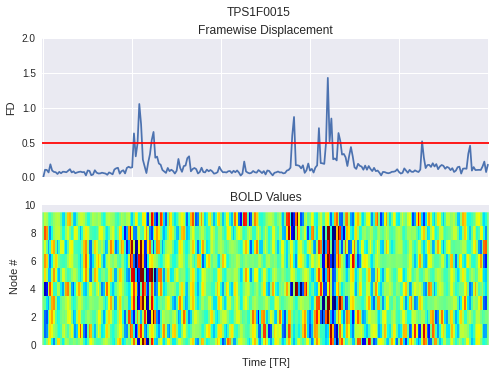

/data00/tools/Canopy_64bit/User/lib/python2.7/site-packages/sklearn/externals/joblib/hashing.py:197: DeprecationWarning: Changing the shape of non-C contiguous array by
descriptor assignment is deprecated. To maintain
the Fortran contiguity of a multidimensional Fortran
array, use 'a.T.view(...).T' instead
  obj_bytes_view = obj.view(self.np.uint8)
/data00/tools/Canopy_64bit/User/lib/python2.7/site-packages/sklearn/externals/joblib/hashing.py:197: DeprecationWarning: Changing the shape of non-C contiguous array by
descriptor assignment is deprecated. To maintain
the Fortran contiguity of a multidimensional Fortran
array, use 'a.T.view(...).T' instead
  obj_bytes_view = obj.view(self.np.uint8)
/data00/tools/Canopy_64bit/User/lib/python2.7/site-packages/sklearn/externals/joblib/hashing.py:197: DeprecationWarning: Changing the shape of non-C contiguous array by
descriptor assignment is deprecated. To maintain
the Fortran contiguity of a multidimensional Fortran
array, use 'a.T.view(...).T

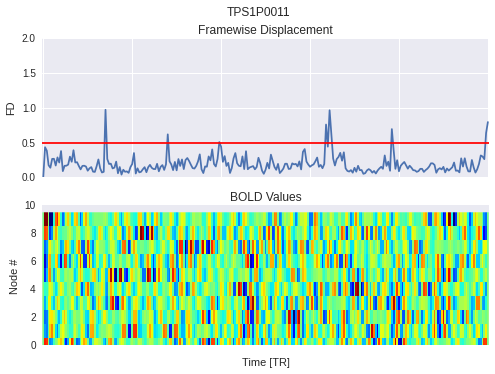

/data00/tools/Canopy_64bit/User/lib/python2.7/site-packages/sklearn/externals/joblib/hashing.py:197: DeprecationWarning: Changing the shape of non-C contiguous array by
descriptor assignment is deprecated. To maintain
the Fortran contiguity of a multidimensional Fortran
array, use 'a.T.view(...).T' instead
  obj_bytes_view = obj.view(self.np.uint8)
/data00/tools/Canopy_64bit/User/lib/python2.7/site-packages/sklearn/externals/joblib/hashing.py:197: DeprecationWarning: Changing the shape of non-C contiguous array by
descriptor assignment is deprecated. To maintain
the Fortran contiguity of a multidimensional Fortran
array, use 'a.T.view(...).T' instead
  obj_bytes_view = obj.view(self.np.uint8)
/data00/tools/Canopy_64bit/User/lib/python2.7/site-packages/sklearn/externals/joblib/hashing.py:197: DeprecationWarning: Changing the shape of non-C contiguous array by
descriptor assignment is deprecated. To maintain
the Fortran contiguity of a multidimensional Fortran
array, use 'a.T.view(...).T

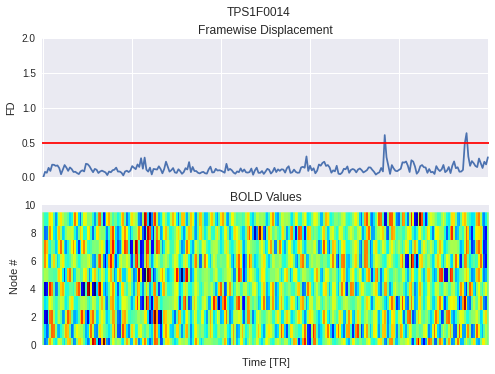

/data00/tools/Canopy_64bit/User/lib/python2.7/site-packages/sklearn/externals/joblib/hashing.py:197: DeprecationWarning: Changing the shape of non-C contiguous array by
descriptor assignment is deprecated. To maintain
the Fortran contiguity of a multidimensional Fortran
array, use 'a.T.view(...).T' instead
  obj_bytes_view = obj.view(self.np.uint8)
/data00/tools/Canopy_64bit/User/lib/python2.7/site-packages/sklearn/externals/joblib/hashing.py:197: DeprecationWarning: Changing the shape of non-C contiguous array by
descriptor assignment is deprecated. To maintain
the Fortran contiguity of a multidimensional Fortran
array, use 'a.T.view(...).T' instead
  obj_bytes_view = obj.view(self.np.uint8)
/data00/tools/Canopy_64bit/User/lib/python2.7/site-packages/sklearn/externals/joblib/hashing.py:197: DeprecationWarning: Changing the shape of non-C contiguous array by
descriptor assignment is deprecated. To maintain
the Fortran contiguity of a multidimensional Fortran
array, use 'a.T.view(...).T

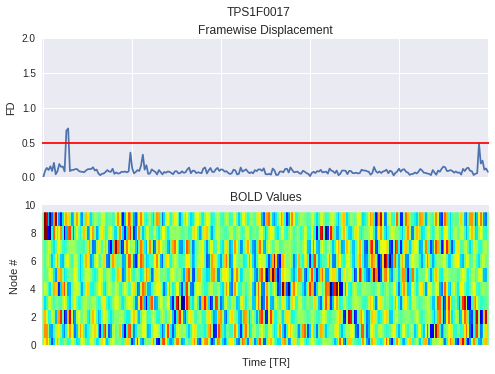

/data00/tools/Canopy_64bit/User/lib/python2.7/site-packages/sklearn/externals/joblib/hashing.py:197: DeprecationWarning: Changing the shape of non-C contiguous array by
descriptor assignment is deprecated. To maintain
the Fortran contiguity of a multidimensional Fortran
array, use 'a.T.view(...).T' instead
  obj_bytes_view = obj.view(self.np.uint8)
/data00/tools/Canopy_64bit/User/lib/python2.7/site-packages/sklearn/externals/joblib/hashing.py:197: DeprecationWarning: Changing the shape of non-C contiguous array by
descriptor assignment is deprecated. To maintain
the Fortran contiguity of a multidimensional Fortran
array, use 'a.T.view(...).T' instead
  obj_bytes_view = obj.view(self.np.uint8)
/data00/tools/Canopy_64bit/User/lib/python2.7/site-packages/sklearn/externals/joblib/hashing.py:197: DeprecationWarning: Changing the shape of non-C contiguous array by
descriptor assignment is deprecated. To maintain
the Fortran contiguity of a multidimensional Fortran
array, use 'a.T.view(...).T

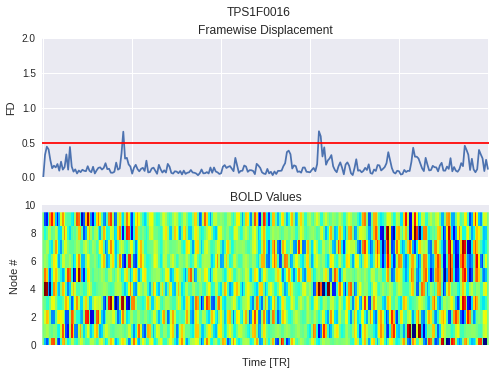

/data00/tools/Canopy_64bit/User/lib/python2.7/site-packages/sklearn/externals/joblib/hashing.py:197: DeprecationWarning: Changing the shape of non-C contiguous array by
descriptor assignment is deprecated. To maintain
the Fortran contiguity of a multidimensional Fortran
array, use 'a.T.view(...).T' instead
  obj_bytes_view = obj.view(self.np.uint8)
/data00/tools/Canopy_64bit/User/lib/python2.7/site-packages/sklearn/externals/joblib/hashing.py:197: DeprecationWarning: Changing the shape of non-C contiguous array by
descriptor assignment is deprecated. To maintain
the Fortran contiguity of a multidimensional Fortran
array, use 'a.T.view(...).T' instead
  obj_bytes_view = obj.view(self.np.uint8)
/data00/tools/Canopy_64bit/User/lib/python2.7/site-packages/sklearn/externals/joblib/hashing.py:197: DeprecationWarning: Changing the shape of non-C contiguous array by
descriptor assignment is deprecated. To maintain
the Fortran contiguity of a multidimensional Fortran
array, use 'a.T.view(...).T

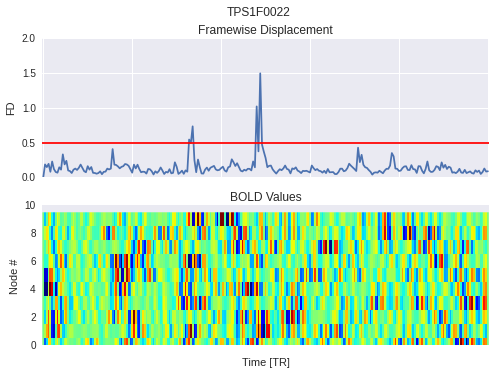

/data00/tools/Canopy_64bit/User/lib/python2.7/site-packages/sklearn/externals/joblib/hashing.py:197: DeprecationWarning: Changing the shape of non-C contiguous array by
descriptor assignment is deprecated. To maintain
the Fortran contiguity of a multidimensional Fortran
array, use 'a.T.view(...).T' instead
  obj_bytes_view = obj.view(self.np.uint8)
/data00/tools/Canopy_64bit/User/lib/python2.7/site-packages/sklearn/externals/joblib/hashing.py:197: DeprecationWarning: Changing the shape of non-C contiguous array by
descriptor assignment is deprecated. To maintain
the Fortran contiguity of a multidimensional Fortran
array, use 'a.T.view(...).T' instead
  obj_bytes_view = obj.view(self.np.uint8)
/data00/tools/Canopy_64bit/User/lib/python2.7/site-packages/sklearn/externals/joblib/hashing.py:197: DeprecationWarning: Changing the shape of non-C contiguous array by
descriptor assignment is deprecated. To maintain
the Fortran contiguity of a multidimensional Fortran
array, use 'a.T.view(...).T

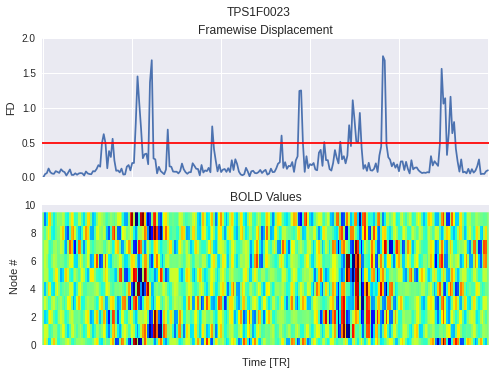

/data00/tools/Canopy_64bit/User/lib/python2.7/site-packages/sklearn/externals/joblib/hashing.py:197: DeprecationWarning: Changing the shape of non-C contiguous array by
descriptor assignment is deprecated. To maintain
the Fortran contiguity of a multidimensional Fortran
array, use 'a.T.view(...).T' instead
  obj_bytes_view = obj.view(self.np.uint8)
/data00/tools/Canopy_64bit/User/lib/python2.7/site-packages/sklearn/externals/joblib/hashing.py:197: DeprecationWarning: Changing the shape of non-C contiguous array by
descriptor assignment is deprecated. To maintain
the Fortran contiguity of a multidimensional Fortran
array, use 'a.T.view(...).T' instead
  obj_bytes_view = obj.view(self.np.uint8)
/data00/tools/Canopy_64bit/User/lib/python2.7/site-packages/sklearn/externals/joblib/hashing.py:197: DeprecationWarning: Changing the shape of non-C contiguous array by
descriptor assignment is deprecated. To maintain
the Fortran contiguity of a multidimensional Fortran
array, use 'a.T.view(...).T

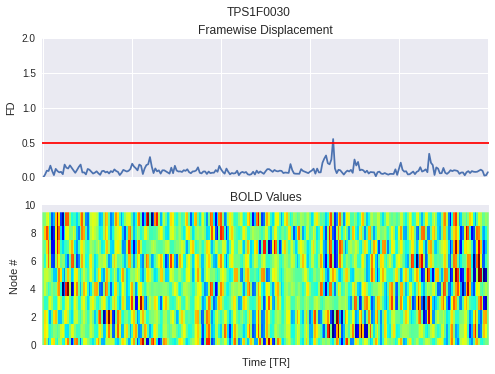

/data00/tools/Canopy_64bit/User/lib/python2.7/site-packages/sklearn/externals/joblib/hashing.py:197: DeprecationWarning: Changing the shape of non-C contiguous array by
descriptor assignment is deprecated. To maintain
the Fortran contiguity of a multidimensional Fortran
array, use 'a.T.view(...).T' instead
  obj_bytes_view = obj.view(self.np.uint8)
/data00/tools/Canopy_64bit/User/lib/python2.7/site-packages/sklearn/externals/joblib/hashing.py:197: DeprecationWarning: Changing the shape of non-C contiguous array by
descriptor assignment is deprecated. To maintain
the Fortran contiguity of a multidimensional Fortran
array, use 'a.T.view(...).T' instead
  obj_bytes_view = obj.view(self.np.uint8)
/data00/tools/Canopy_64bit/User/lib/python2.7/site-packages/sklearn/externals/joblib/hashing.py:197: DeprecationWarning: Changing the shape of non-C contiguous array by
descriptor assignment is deprecated. To maintain
the Fortran contiguity of a multidimensional Fortran
array, use 'a.T.view(...).T

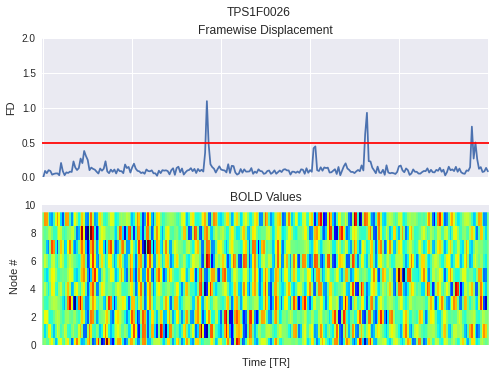

/data00/tools/Canopy_64bit/User/lib/python2.7/site-packages/sklearn/externals/joblib/hashing.py:197: DeprecationWarning: Changing the shape of non-C contiguous array by
descriptor assignment is deprecated. To maintain
the Fortran contiguity of a multidimensional Fortran
array, use 'a.T.view(...).T' instead
  obj_bytes_view = obj.view(self.np.uint8)
/data00/tools/Canopy_64bit/User/lib/python2.7/site-packages/sklearn/externals/joblib/hashing.py:197: DeprecationWarning: Changing the shape of non-C contiguous array by
descriptor assignment is deprecated. To maintain
the Fortran contiguity of a multidimensional Fortran
array, use 'a.T.view(...).T' instead
  obj_bytes_view = obj.view(self.np.uint8)
/data00/tools/Canopy_64bit/User/lib/python2.7/site-packages/sklearn/externals/joblib/hashing.py:197: DeprecationWarning: Changing the shape of non-C contiguous array by
descriptor assignment is deprecated. To maintain
the Fortran contiguity of a multidimensional Fortran
array, use 'a.T.view(...).T

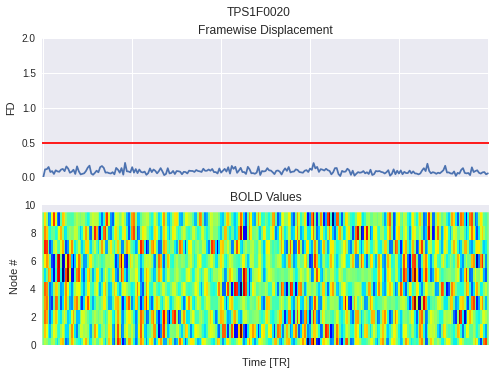

/data00/tools/Canopy_64bit/User/lib/python2.7/site-packages/sklearn/externals/joblib/hashing.py:197: DeprecationWarning: Changing the shape of non-C contiguous array by
descriptor assignment is deprecated. To maintain
the Fortran contiguity of a multidimensional Fortran
array, use 'a.T.view(...).T' instead
  obj_bytes_view = obj.view(self.np.uint8)
/data00/tools/Canopy_64bit/User/lib/python2.7/site-packages/sklearn/externals/joblib/hashing.py:197: DeprecationWarning: Changing the shape of non-C contiguous array by
descriptor assignment is deprecated. To maintain
the Fortran contiguity of a multidimensional Fortran
array, use 'a.T.view(...).T' instead
  obj_bytes_view = obj.view(self.np.uint8)
/data00/tools/Canopy_64bit/User/lib/python2.7/site-packages/sklearn/externals/joblib/hashing.py:197: DeprecationWarning: Changing the shape of non-C contiguous array by
descriptor assignment is deprecated. To maintain
the Fortran contiguity of a multidimensional Fortran
array, use 'a.T.view(...).T

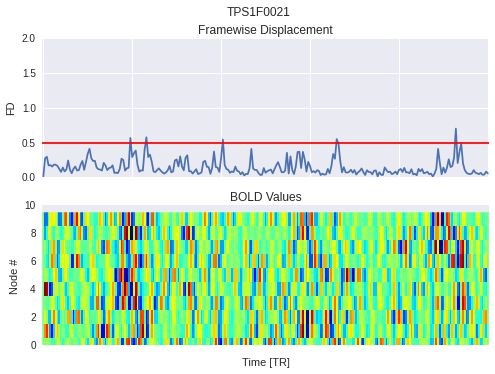

/data00/tools/Canopy_64bit/User/lib/python2.7/site-packages/sklearn/externals/joblib/hashing.py:197: DeprecationWarning: Changing the shape of non-C contiguous array by
descriptor assignment is deprecated. To maintain
the Fortran contiguity of a multidimensional Fortran
array, use 'a.T.view(...).T' instead
  obj_bytes_view = obj.view(self.np.uint8)
/data00/tools/Canopy_64bit/User/lib/python2.7/site-packages/sklearn/externals/joblib/hashing.py:197: DeprecationWarning: Changing the shape of non-C contiguous array by
descriptor assignment is deprecated. To maintain
the Fortran contiguity of a multidimensional Fortran
array, use 'a.T.view(...).T' instead
  obj_bytes_view = obj.view(self.np.uint8)
/data00/tools/Canopy_64bit/User/lib/python2.7/site-packages/sklearn/externals/joblib/hashing.py:197: DeprecationWarning: Changing the shape of non-C contiguous array by
descriptor assignment is deprecated. To maintain
the Fortran contiguity of a multidimensional Fortran
array, use 'a.T.view(...).T

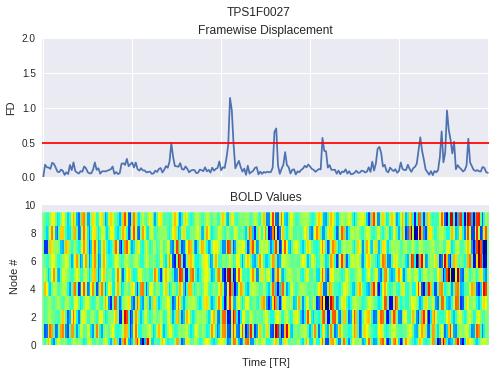

/data00/tools/Canopy_64bit/User/lib/python2.7/site-packages/sklearn/externals/joblib/hashing.py:197: DeprecationWarning: Changing the shape of non-C contiguous array by
descriptor assignment is deprecated. To maintain
the Fortran contiguity of a multidimensional Fortran
array, use 'a.T.view(...).T' instead
  obj_bytes_view = obj.view(self.np.uint8)
/data00/tools/Canopy_64bit/User/lib/python2.7/site-packages/sklearn/externals/joblib/hashing.py:197: DeprecationWarning: Changing the shape of non-C contiguous array by
descriptor assignment is deprecated. To maintain
the Fortran contiguity of a multidimensional Fortran
array, use 'a.T.view(...).T' instead
  obj_bytes_view = obj.view(self.np.uint8)
/data00/tools/Canopy_64bit/User/lib/python2.7/site-packages/sklearn/externals/joblib/hashing.py:197: DeprecationWarning: Changing the shape of non-C contiguous array by
descriptor assignment is deprecated. To maintain
the Fortran contiguity of a multidimensional Fortran
array, use 'a.T.view(...).T

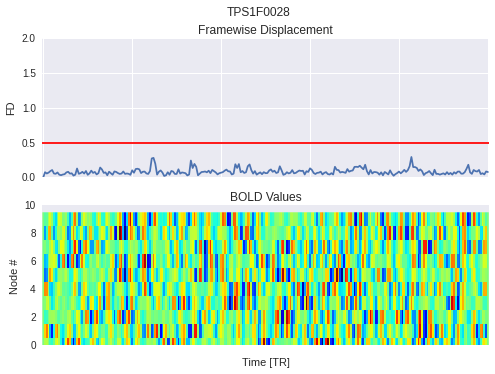

/data00/tools/Canopy_64bit/User/lib/python2.7/site-packages/sklearn/externals/joblib/hashing.py:197: DeprecationWarning: Changing the shape of non-C contiguous array by
descriptor assignment is deprecated. To maintain
the Fortran contiguity of a multidimensional Fortran
array, use 'a.T.view(...).T' instead
  obj_bytes_view = obj.view(self.np.uint8)
/data00/tools/Canopy_64bit/User/lib/python2.7/site-packages/sklearn/externals/joblib/hashing.py:197: DeprecationWarning: Changing the shape of non-C contiguous array by
descriptor assignment is deprecated. To maintain
the Fortran contiguity of a multidimensional Fortran
array, use 'a.T.view(...).T' instead
  obj_bytes_view = obj.view(self.np.uint8)
/data00/tools/Canopy_64bit/User/lib/python2.7/site-packages/sklearn/externals/joblib/hashing.py:197: DeprecationWarning: Changing the shape of non-C contiguous array by
descriptor assignment is deprecated. To maintain
the Fortran contiguity of a multidimensional Fortran
array, use 'a.T.view(...).T

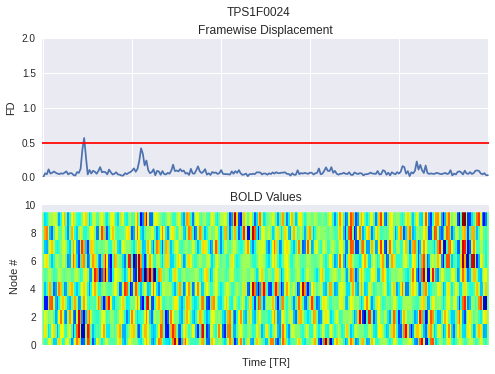

/data00/tools/Canopy_64bit/User/lib/python2.7/site-packages/sklearn/externals/joblib/hashing.py:197: DeprecationWarning: Changing the shape of non-C contiguous array by
descriptor assignment is deprecated. To maintain
the Fortran contiguity of a multidimensional Fortran
array, use 'a.T.view(...).T' instead
  obj_bytes_view = obj.view(self.np.uint8)
/data00/tools/Canopy_64bit/User/lib/python2.7/site-packages/sklearn/externals/joblib/hashing.py:197: DeprecationWarning: Changing the shape of non-C contiguous array by
descriptor assignment is deprecated. To maintain
the Fortran contiguity of a multidimensional Fortran
array, use 'a.T.view(...).T' instead
  obj_bytes_view = obj.view(self.np.uint8)
/data00/tools/Canopy_64bit/User/lib/python2.7/site-packages/sklearn/externals/joblib/hashing.py:197: DeprecationWarning: Changing the shape of non-C contiguous array by
descriptor assignment is deprecated. To maintain
the Fortran contiguity of a multidimensional Fortran
array, use 'a.T.view(...).T

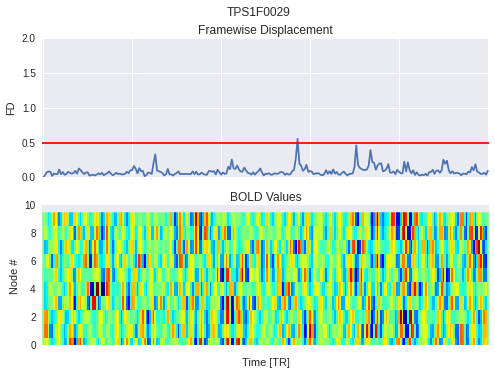

/data00/tools/Canopy_64bit/User/lib/python2.7/site-packages/sklearn/externals/joblib/hashing.py:197: DeprecationWarning: Changing the shape of non-C contiguous array by
descriptor assignment is deprecated. To maintain
the Fortran contiguity of a multidimensional Fortran
array, use 'a.T.view(...).T' instead
  obj_bytes_view = obj.view(self.np.uint8)
/data00/tools/Canopy_64bit/User/lib/python2.7/site-packages/sklearn/externals/joblib/hashing.py:197: DeprecationWarning: Changing the shape of non-C contiguous array by
descriptor assignment is deprecated. To maintain
the Fortran contiguity of a multidimensional Fortran
array, use 'a.T.view(...).T' instead
  obj_bytes_view = obj.view(self.np.uint8)
/data00/tools/Canopy_64bit/User/lib/python2.7/site-packages/sklearn/externals/joblib/hashing.py:197: DeprecationWarning: Changing the shape of non-C contiguous array by
descriptor assignment is deprecated. To maintain
the Fortran contiguity of a multidimensional Fortran
array, use 'a.T.view(...).T

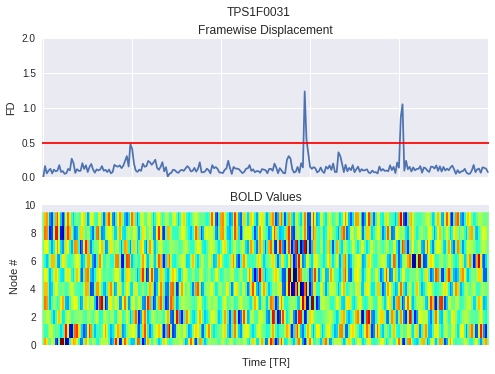

/data00/tools/Canopy_64bit/User/lib/python2.7/site-packages/sklearn/externals/joblib/hashing.py:197: DeprecationWarning: Changing the shape of non-C contiguous array by
descriptor assignment is deprecated. To maintain
the Fortran contiguity of a multidimensional Fortran
array, use 'a.T.view(...).T' instead
  obj_bytes_view = obj.view(self.np.uint8)
/data00/tools/Canopy_64bit/User/lib/python2.7/site-packages/sklearn/externals/joblib/hashing.py:197: DeprecationWarning: Changing the shape of non-C contiguous array by
descriptor assignment is deprecated. To maintain
the Fortran contiguity of a multidimensional Fortran
array, use 'a.T.view(...).T' instead
  obj_bytes_view = obj.view(self.np.uint8)
/data00/tools/Canopy_64bit/User/lib/python2.7/site-packages/sklearn/externals/joblib/hashing.py:197: DeprecationWarning: Changing the shape of non-C contiguous array by
descriptor assignment is deprecated. To maintain
the Fortran contiguity of a multidimensional Fortran
array, use 'a.T.view(...).T

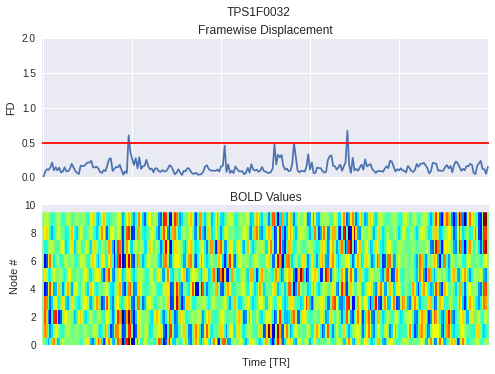

/data00/tools/Canopy_64bit/User/lib/python2.7/site-packages/sklearn/externals/joblib/hashing.py:197: DeprecationWarning: Changing the shape of non-C contiguous array by
descriptor assignment is deprecated. To maintain
the Fortran contiguity of a multidimensional Fortran
array, use 'a.T.view(...).T' instead
  obj_bytes_view = obj.view(self.np.uint8)
/data00/tools/Canopy_64bit/User/lib/python2.7/site-packages/sklearn/externals/joblib/hashing.py:197: DeprecationWarning: Changing the shape of non-C contiguous array by
descriptor assignment is deprecated. To maintain
the Fortran contiguity of a multidimensional Fortran
array, use 'a.T.view(...).T' instead
  obj_bytes_view = obj.view(self.np.uint8)
/data00/tools/Canopy_64bit/User/lib/python2.7/site-packages/sklearn/externals/joblib/hashing.py:197: DeprecationWarning: Changing the shape of non-C contiguous array by
descriptor assignment is deprecated. To maintain
the Fortran contiguity of a multidimensional Fortran
array, use 'a.T.view(...).T

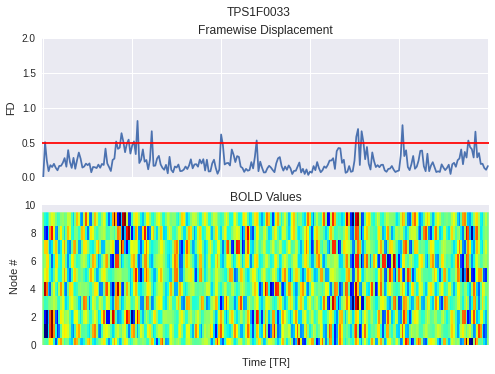

/data00/tools/Canopy_64bit/User/lib/python2.7/site-packages/sklearn/externals/joblib/hashing.py:197: DeprecationWarning: Changing the shape of non-C contiguous array by
descriptor assignment is deprecated. To maintain
the Fortran contiguity of a multidimensional Fortran
array, use 'a.T.view(...).T' instead
  obj_bytes_view = obj.view(self.np.uint8)
/data00/tools/Canopy_64bit/User/lib/python2.7/site-packages/sklearn/externals/joblib/hashing.py:197: DeprecationWarning: Changing the shape of non-C contiguous array by
descriptor assignment is deprecated. To maintain
the Fortran contiguity of a multidimensional Fortran
array, use 'a.T.view(...).T' instead
  obj_bytes_view = obj.view(self.np.uint8)
/data00/tools/Canopy_64bit/User/lib/python2.7/site-packages/sklearn/externals/joblib/hashing.py:197: DeprecationWarning: Changing the shape of non-C contiguous array by
descriptor assignment is deprecated. To maintain
the Fortran contiguity of a multidimensional Fortran
array, use 'a.T.view(...).T

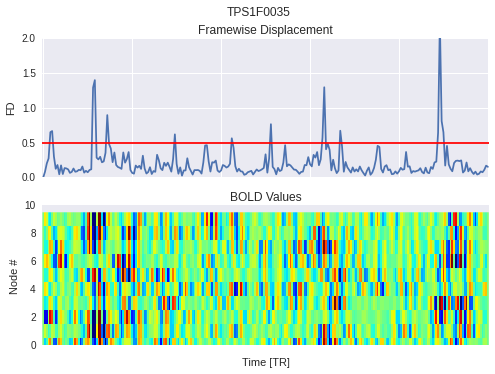

/data00/tools/Canopy_64bit/User/lib/python2.7/site-packages/sklearn/externals/joblib/hashing.py:197: DeprecationWarning: Changing the shape of non-C contiguous array by
descriptor assignment is deprecated. To maintain
the Fortran contiguity of a multidimensional Fortran
array, use 'a.T.view(...).T' instead
  obj_bytes_view = obj.view(self.np.uint8)
/data00/tools/Canopy_64bit/User/lib/python2.7/site-packages/sklearn/externals/joblib/hashing.py:197: DeprecationWarning: Changing the shape of non-C contiguous array by
descriptor assignment is deprecated. To maintain
the Fortran contiguity of a multidimensional Fortran
array, use 'a.T.view(...).T' instead
  obj_bytes_view = obj.view(self.np.uint8)
/data00/tools/Canopy_64bit/User/lib/python2.7/site-packages/sklearn/externals/joblib/hashing.py:197: DeprecationWarning: Changing the shape of non-C contiguous array by
descriptor assignment is deprecated. To maintain
the Fortran contiguity of a multidimensional Fortran
array, use 'a.T.view(...).T

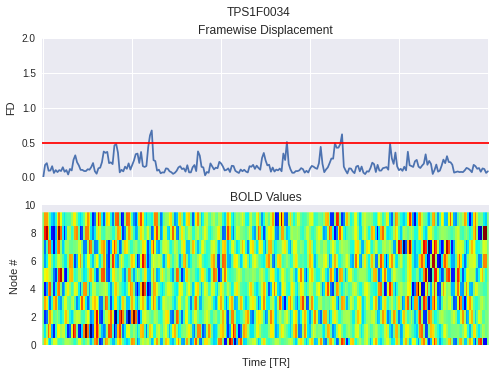

/data00/tools/Canopy_64bit/User/lib/python2.7/site-packages/sklearn/externals/joblib/hashing.py:197: DeprecationWarning: Changing the shape of non-C contiguous array by
descriptor assignment is deprecated. To maintain
the Fortran contiguity of a multidimensional Fortran
array, use 'a.T.view(...).T' instead
  obj_bytes_view = obj.view(self.np.uint8)
/data00/tools/Canopy_64bit/User/lib/python2.7/site-packages/sklearn/externals/joblib/hashing.py:197: DeprecationWarning: Changing the shape of non-C contiguous array by
descriptor assignment is deprecated. To maintain
the Fortran contiguity of a multidimensional Fortran
array, use 'a.T.view(...).T' instead
  obj_bytes_view = obj.view(self.np.uint8)
/data00/tools/Canopy_64bit/User/lib/python2.7/site-packages/sklearn/externals/joblib/hashing.py:197: DeprecationWarning: Changing the shape of non-C contiguous array by
descriptor assignment is deprecated. To maintain
the Fortran contiguity of a multidimensional Fortran
array, use 'a.T.view(...).T

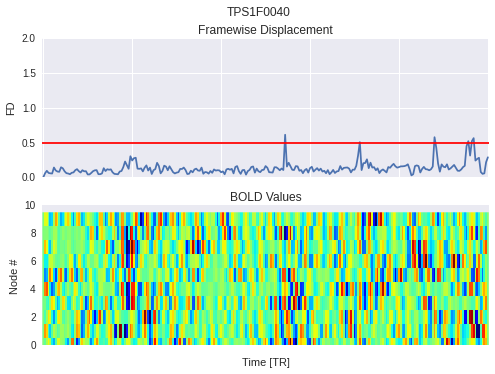

/data00/tools/Canopy_64bit/User/lib/python2.7/site-packages/sklearn/externals/joblib/hashing.py:197: DeprecationWarning: Changing the shape of non-C contiguous array by
descriptor assignment is deprecated. To maintain
the Fortran contiguity of a multidimensional Fortran
array, use 'a.T.view(...).T' instead
  obj_bytes_view = obj.view(self.np.uint8)
/data00/tools/Canopy_64bit/User/lib/python2.7/site-packages/sklearn/externals/joblib/hashing.py:197: DeprecationWarning: Changing the shape of non-C contiguous array by
descriptor assignment is deprecated. To maintain
the Fortran contiguity of a multidimensional Fortran
array, use 'a.T.view(...).T' instead
  obj_bytes_view = obj.view(self.np.uint8)
/data00/tools/Canopy_64bit/User/lib/python2.7/site-packages/sklearn/externals/joblib/hashing.py:197: DeprecationWarning: Changing the shape of non-C contiguous array by
descriptor assignment is deprecated. To maintain
the Fortran contiguity of a multidimensional Fortran
array, use 'a.T.view(...).T

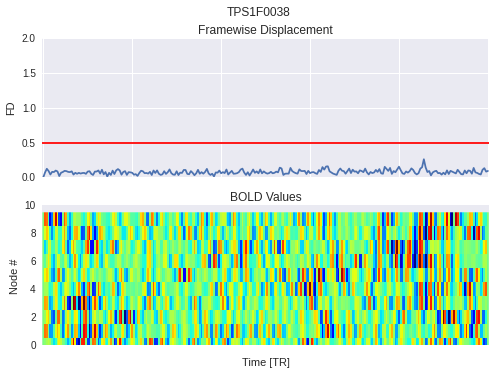

/data00/tools/Canopy_64bit/User/lib/python2.7/site-packages/sklearn/externals/joblib/hashing.py:197: DeprecationWarning: Changing the shape of non-C contiguous array by
descriptor assignment is deprecated. To maintain
the Fortran contiguity of a multidimensional Fortran
array, use 'a.T.view(...).T' instead
  obj_bytes_view = obj.view(self.np.uint8)
/data00/tools/Canopy_64bit/User/lib/python2.7/site-packages/sklearn/externals/joblib/hashing.py:197: DeprecationWarning: Changing the shape of non-C contiguous array by
descriptor assignment is deprecated. To maintain
the Fortran contiguity of a multidimensional Fortran
array, use 'a.T.view(...).T' instead
  obj_bytes_view = obj.view(self.np.uint8)
/data00/tools/Canopy_64bit/User/lib/python2.7/site-packages/sklearn/externals/joblib/hashing.py:197: DeprecationWarning: Changing the shape of non-C contiguous array by
descriptor assignment is deprecated. To maintain
the Fortran contiguity of a multidimensional Fortran
array, use 'a.T.view(...).T

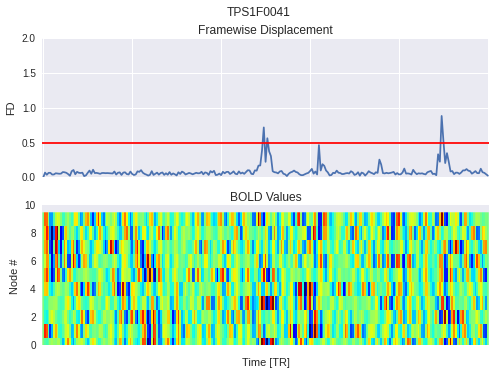

/data00/tools/Canopy_64bit/User/lib/python2.7/site-packages/sklearn/externals/joblib/hashing.py:197: DeprecationWarning: Changing the shape of non-C contiguous array by
descriptor assignment is deprecated. To maintain
the Fortran contiguity of a multidimensional Fortran
array, use 'a.T.view(...).T' instead
  obj_bytes_view = obj.view(self.np.uint8)
/data00/tools/Canopy_64bit/User/lib/python2.7/site-packages/sklearn/externals/joblib/hashing.py:197: DeprecationWarning: Changing the shape of non-C contiguous array by
descriptor assignment is deprecated. To maintain
the Fortran contiguity of a multidimensional Fortran
array, use 'a.T.view(...).T' instead
  obj_bytes_view = obj.view(self.np.uint8)
/data00/tools/Canopy_64bit/User/lib/python2.7/site-packages/sklearn/externals/joblib/hashing.py:197: DeprecationWarning: Changing the shape of non-C contiguous array by
descriptor assignment is deprecated. To maintain
the Fortran contiguity of a multidimensional Fortran
array, use 'a.T.view(...).T

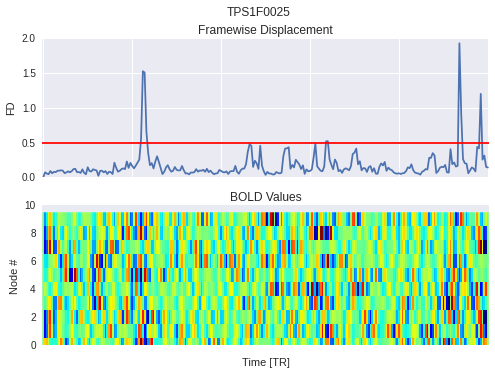

/data00/tools/Canopy_64bit/User/lib/python2.7/site-packages/sklearn/externals/joblib/hashing.py:197: DeprecationWarning: Changing the shape of non-C contiguous array by
descriptor assignment is deprecated. To maintain
the Fortran contiguity of a multidimensional Fortran
array, use 'a.T.view(...).T' instead
  obj_bytes_view = obj.view(self.np.uint8)
/data00/tools/Canopy_64bit/User/lib/python2.7/site-packages/sklearn/externals/joblib/hashing.py:197: DeprecationWarning: Changing the shape of non-C contiguous array by
descriptor assignment is deprecated. To maintain
the Fortran contiguity of a multidimensional Fortran
array, use 'a.T.view(...).T' instead
  obj_bytes_view = obj.view(self.np.uint8)
/data00/tools/Canopy_64bit/User/lib/python2.7/site-packages/sklearn/externals/joblib/hashing.py:197: DeprecationWarning: Changing the shape of non-C contiguous array by
descriptor assignment is deprecated. To maintain
the Fortran contiguity of a multidimensional Fortran
array, use 'a.T.view(...).T

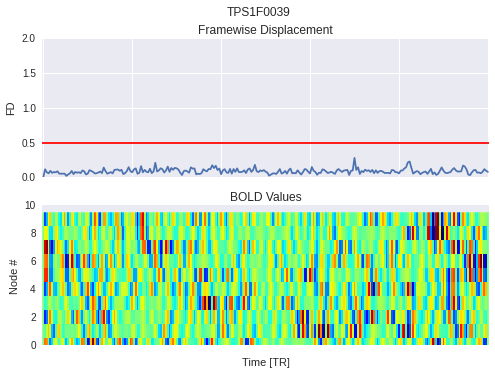

/data00/tools/Canopy_64bit/User/lib/python2.7/site-packages/sklearn/externals/joblib/hashing.py:197: DeprecationWarning: Changing the shape of non-C contiguous array by
descriptor assignment is deprecated. To maintain
the Fortran contiguity of a multidimensional Fortran
array, use 'a.T.view(...).T' instead
  obj_bytes_view = obj.view(self.np.uint8)
/data00/tools/Canopy_64bit/User/lib/python2.7/site-packages/sklearn/externals/joblib/hashing.py:197: DeprecationWarning: Changing the shape of non-C contiguous array by
descriptor assignment is deprecated. To maintain
the Fortran contiguity of a multidimensional Fortran
array, use 'a.T.view(...).T' instead
  obj_bytes_view = obj.view(self.np.uint8)
/data00/tools/Canopy_64bit/User/lib/python2.7/site-packages/sklearn/externals/joblib/hashing.py:197: DeprecationWarning: Changing the shape of non-C contiguous array by
descriptor assignment is deprecated. To maintain
the Fortran contiguity of a multidimensional Fortran
array, use 'a.T.view(...).T

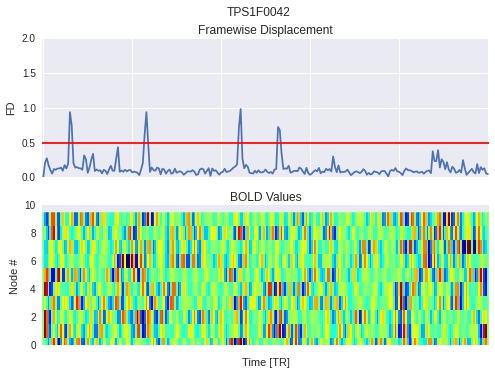

/data00/tools/Canopy_64bit/User/lib/python2.7/site-packages/sklearn/externals/joblib/hashing.py:197: DeprecationWarning: Changing the shape of non-C contiguous array by
descriptor assignment is deprecated. To maintain
the Fortran contiguity of a multidimensional Fortran
array, use 'a.T.view(...).T' instead
  obj_bytes_view = obj.view(self.np.uint8)
/data00/tools/Canopy_64bit/User/lib/python2.7/site-packages/sklearn/externals/joblib/hashing.py:197: DeprecationWarning: Changing the shape of non-C contiguous array by
descriptor assignment is deprecated. To maintain
the Fortran contiguity of a multidimensional Fortran
array, use 'a.T.view(...).T' instead
  obj_bytes_view = obj.view(self.np.uint8)
/data00/tools/Canopy_64bit/User/lib/python2.7/site-packages/sklearn/externals/joblib/hashing.py:197: DeprecationWarning: Changing the shape of non-C contiguous array by
descriptor assignment is deprecated. To maintain
the Fortran contiguity of a multidimensional Fortran
array, use 'a.T.view(...).T

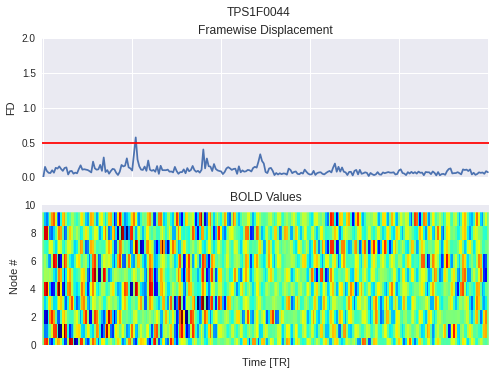

/data00/tools/Canopy_64bit/User/lib/python2.7/site-packages/sklearn/externals/joblib/hashing.py:197: DeprecationWarning: Changing the shape of non-C contiguous array by
descriptor assignment is deprecated. To maintain
the Fortran contiguity of a multidimensional Fortran
array, use 'a.T.view(...).T' instead
  obj_bytes_view = obj.view(self.np.uint8)
/data00/tools/Canopy_64bit/User/lib/python2.7/site-packages/sklearn/externals/joblib/hashing.py:197: DeprecationWarning: Changing the shape of non-C contiguous array by
descriptor assignment is deprecated. To maintain
the Fortran contiguity of a multidimensional Fortran
array, use 'a.T.view(...).T' instead
  obj_bytes_view = obj.view(self.np.uint8)
/data00/tools/Canopy_64bit/User/lib/python2.7/site-packages/sklearn/externals/joblib/hashing.py:197: DeprecationWarning: Changing the shape of non-C contiguous array by
descriptor assignment is deprecated. To maintain
the Fortran contiguity of a multidimensional Fortran
array, use 'a.T.view(...).T

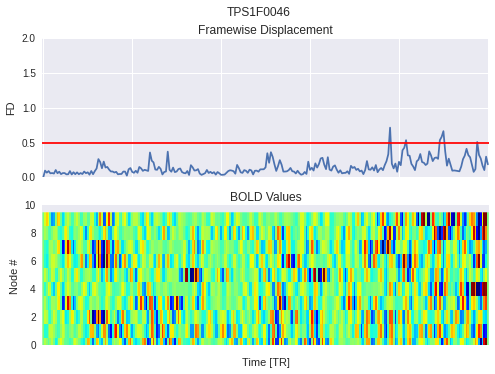

/data00/tools/Canopy_64bit/User/lib/python2.7/site-packages/sklearn/externals/joblib/hashing.py:197: DeprecationWarning: Changing the shape of non-C contiguous array by
descriptor assignment is deprecated. To maintain
the Fortran contiguity of a multidimensional Fortran
array, use 'a.T.view(...).T' instead
  obj_bytes_view = obj.view(self.np.uint8)
/data00/tools/Canopy_64bit/User/lib/python2.7/site-packages/sklearn/externals/joblib/hashing.py:197: DeprecationWarning: Changing the shape of non-C contiguous array by
descriptor assignment is deprecated. To maintain
the Fortran contiguity of a multidimensional Fortran
array, use 'a.T.view(...).T' instead
  obj_bytes_view = obj.view(self.np.uint8)
/data00/tools/Canopy_64bit/User/lib/python2.7/site-packages/sklearn/externals/joblib/hashing.py:197: DeprecationWarning: Changing the shape of non-C contiguous array by
descriptor assignment is deprecated. To maintain
the Fortran contiguity of a multidimensional Fortran
array, use 'a.T.view(...).T

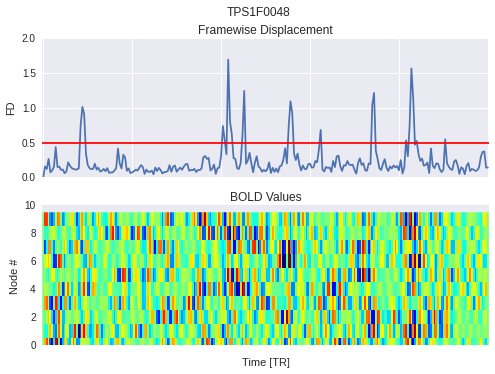

/data00/tools/Canopy_64bit/User/lib/python2.7/site-packages/sklearn/externals/joblib/hashing.py:197: DeprecationWarning: Changing the shape of non-C contiguous array by
descriptor assignment is deprecated. To maintain
the Fortran contiguity of a multidimensional Fortran
array, use 'a.T.view(...).T' instead
  obj_bytes_view = obj.view(self.np.uint8)
/data00/tools/Canopy_64bit/User/lib/python2.7/site-packages/sklearn/externals/joblib/hashing.py:197: DeprecationWarning: Changing the shape of non-C contiguous array by
descriptor assignment is deprecated. To maintain
the Fortran contiguity of a multidimensional Fortran
array, use 'a.T.view(...).T' instead
  obj_bytes_view = obj.view(self.np.uint8)
/data00/tools/Canopy_64bit/User/lib/python2.7/site-packages/sklearn/externals/joblib/hashing.py:197: DeprecationWarning: Changing the shape of non-C contiguous array by
descriptor assignment is deprecated. To maintain
the Fortran contiguity of a multidimensional Fortran
array, use 'a.T.view(...).T

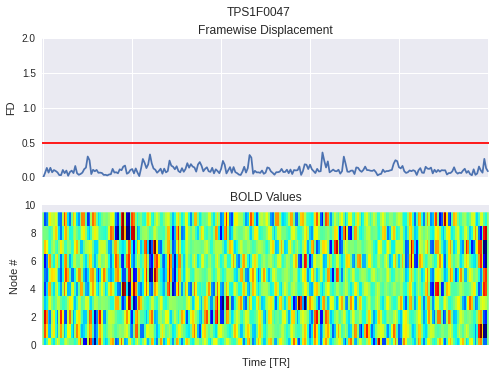

/data00/tools/Canopy_64bit/User/lib/python2.7/site-packages/sklearn/externals/joblib/hashing.py:197: DeprecationWarning: Changing the shape of non-C contiguous array by
descriptor assignment is deprecated. To maintain
the Fortran contiguity of a multidimensional Fortran
array, use 'a.T.view(...).T' instead
  obj_bytes_view = obj.view(self.np.uint8)
/data00/tools/Canopy_64bit/User/lib/python2.7/site-packages/sklearn/externals/joblib/hashing.py:197: DeprecationWarning: Changing the shape of non-C contiguous array by
descriptor assignment is deprecated. To maintain
the Fortran contiguity of a multidimensional Fortran
array, use 'a.T.view(...).T' instead
  obj_bytes_view = obj.view(self.np.uint8)
/data00/tools/Canopy_64bit/User/lib/python2.7/site-packages/sklearn/externals/joblib/hashing.py:197: DeprecationWarning: Changing the shape of non-C contiguous array by
descriptor assignment is deprecated. To maintain
the Fortran contiguity of a multidimensional Fortran
array, use 'a.T.view(...).T

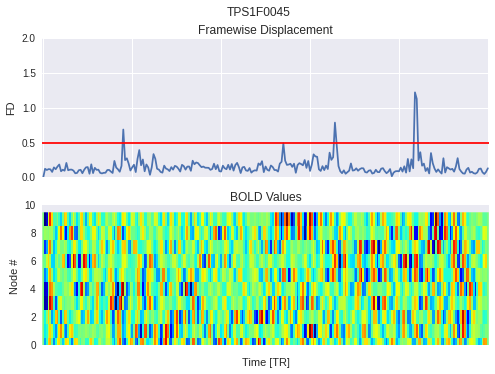

DONE!


In [14]:
nifti_file = 'wadrun_04.nii'
outpath = '/data00/projects/can_cta/data/clean_ts_redo' 
if not os.path.exists(outpath):
    os.makedirs(outpath)

connectome_measure = ConnectivityMeasure(kind='correlation')
all_correlations = []
fd_thresh = 0.5

#print('Working on subject: ')   
for n in range(n_subjs): 
    #sys.stdout.write(subjs[n] +', ')    
                 
    cleaned_time_series, fds, bad_fd_vols,  = clean_time_series(os.path.join(data_dir,'subjs',subjs[n],'BOLD','cyberball') , nifti_file, networks_coords, fd_thresh = fd_thresh) 
    plot_data_fd(cleaned_time_series, FD = fds, FD_thresh = fd_thresh, subj = subjs[n])
    
    fair_extent_TR, unfair_extent_TR = get_TR_ranges(os.path.join(data_dir,'subjs') , subjs[n])                    
    
    clean_ts_fair = cleaned_time_series[(fair_extent_TR[0]+10):fair_extent_TR[1],:];  
    is_bad_fair = bad_fd_vols[(fair_extent_TR[0]+10):fair_extent_TR[1]];      
    fd_clean_ts_fair = clean_ts_fair[(is_bad_fair ==0), :] #censor/scrub out the FD-affected volumes
    #print(len(clean_ts_fair))
    #print(len(fd_clean_ts_fair))
    
    clean_ts_unfair = cleaned_time_series[(unfair_extent_TR[0]+10):unfair_extent_TR[1],:];  
    is_bad_unfair = bad_fd_vols[(unfair_extent_TR[0]+10):unfair_extent_TR[1]];  
    fd_clean_ts_unfair = clean_ts_unfair[(is_bad_unfair ==0), :]
    #print(len(clean_ts_unfair))
    #print(len(fd_clean_ts_unfair))
        
    correlations = connectome_measure.fit_transform([fd_clean_ts_fair, fd_clean_ts_unfair]) #@Doug/Matt: switched to different type here...
    all_correlations.append(correlations)
                     
    np.savez(os.path.join(outpath, (subjs[n] + 'TS_Fair_Unfair_CorrelationMat')), clean_ts_fair, clean_ts_unfair, correlations ) 
print('DONE!')   

# At this point we have the following important variables
# all_correlations - contains the subject-wise list of the corr-mats for fair and unfair
# subjs - the list of subject-ids